# Marker Repo - Cell Annotation

In this notebook, clustered h5ad files can be annotated using the MarkerRepo.
The cell types are identified based on the marker lists

## Loading packages

In [17]:
# The following code block imports packages and functions necessary for performing cell type annotation using the MarkerRepo and other related utilites

import markerrepo.marker_repo as mr
import markerrepo.wrappers as wrap
import markerrepo.annotation as annot
import markerrepo.parsing as pars
import markerrepo.utils as utl
import auto_annotation as auto
import scanpy as sc
import os
import matplotlib.pyplot as plt
import pandas as pd
import inspect
import re
import math

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Settings

Specify path of the cloned repository and the h5ad file which is going to be annotated.

In [18]:
# The repo path and the h5ad file to be analyzed must be specified as information entry 
# annotate_by_marker_and_features-sort is the latest version of the repository, which includes the most recent updates 
# and changes

repo_path = "/mnt/workspace_stud/allstud/wp2/annotate_by_marker_and_features-sort"
h5ad_path = "/mnt/workspace_stud/allstud/wp1/data/2024_02_17/heart_lv_SM-IOBHO.h5ad"

Load anndata and list all possible settings.

In [19]:
adata = sc.read_h5ad(h5ad_path)
annot.list_possible_settings(repo_path, adata=adata)

Possible Settings:
----------------------------------------


/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


1. Available columns to search in MarkerRepo:
  - List name
  - Organism name
  - Taxonomy ID
  - Marker type
  - Submitter name
  - List type
  - Date
  - Source
  - tags_transferred
  - Email
  - Tissue
  - Marker
  - Info

2. Possible organisms or taxon IDs:
  - human 9606
  - mouse 10090
  - zebrafish 7955
  - rat 10114
  - pig 9823
  - medaka 8090
  - chicken 9031
  - drosophila 7215
  - yeast 4932

3. Available columns in adata.obs:
  - n_genes_by_counts
  - log1p_n_genes_by_counts
  - total_counts
  - log1p_total_counts
  - nb_features
  - cell type
  - ontology label
  - ontology id
  - louvain_0.1
  - louvain_0.25
  - louvain_0.5
  - louvain_1
  - leiden_0.1
  - leiden_0.25
  - leiden_0.5
  - leiden_1
  - kmeans_7
  - kmeans_10
  - kmeans_13
  - kmeans_16

4. Available columns in adata.var:
  - louvain_0.1_gini_scores
  - louvain_0.25_gini_scores
  - louvain_0.5_gini_scores
  - louvain_1_gini_scores
  - leiden_0.1_gini_scores
  - leiden_0.25_gini_scores
  - leiden_0.5_gini_sco

Enter general annotation settings.

In [20]:
# Taxonomy ID or Organism Name
# e.g., "human" or 9606
# All the available organisms and their corresponding taxons are listed above
organism = "human"

# .obs is the attribute containing the metadata associated with each cell/sample (cell type, cluster annotations, etc.)
# Column in .obs table where ranked genes groups are stored
# e.g., "rank_genes_groups"
# Enter None if no ranking has been performed yet
rank_genes_column = None

# .var is the attribute that contains the metadata associated with each gene/feature
# Column in .var table where gene symbols or Ensembl IDs are stored
# Enter None if the index column of the .var table already has gene symbols or Ensembl IDs
# that you want to use for your annotation
genes_column = None

# The .obs table column of the clustering you want to annotate (e.g., "leiden", "louvain" or "kmeans")
# If the value is set to "None", you can pick one interactively 
clustering_column_list = auto.get_clustering_column_list(adata=adata)

# Specify whether your index of the .var tables are Ensembl IDs (True) or gene symbols (False)
ensembl = mr.check_ensembl(adata)

# Name of the column to add with the final cell type annotation
# If None, all annotation columns will be kept
celltype_column_name = None

# Whether to delete the created marker lists after annotation or not
delete_lists = True

# 
column_specific_terms={"Source":"panglao", "Organism name":"human"}

# 
mr_parameters = [{"style":"two_column", "file_name":"two_column"}]

Validate general annotation settings and the mr_parameters.

In [8]:
# This function was taken from the MarkerRepo to validate the settings
# The variable clustering_column containing the methods used to cluster the groups of cells is given as a list

auto.auto_validate_settings(settings=mr_parameters, repo_path=repo_path, adata=adata, organism=organism, 
                        rank_genes_column=rank_genes_column, genes_column=genes_column, clustering_column=clustering_column_list, ensembl=ensembl,
                        column_specific_terms=column_specific_terms)

All settings are valid.
Summary of settings:
----------------------------------------
General parameters:
  Repo path: /mnt/workspace_stud/allstud/wp2/annotate_by_marker_and_features-sort
  Organism: human
  Rank genes column: None
  Genes column: None
  Clustering column: ['kmeans_10', 'kmeans_13', 'kmeans_16', 'kmeans_7', 'leiden_0.1', 'leiden_0.25', 'leiden_0.5', 'leiden_1', 'louvain_0.1', 'louvain_0.25', 'louvain_0.5', 'louvain_1']
  Ensembl IDs: False
  Column specific terms:
    1. Column to search: Source, Search terms: panglao
    2. Column to search: Organism name, Search terms: human

Parameters from dictionary:
  1. Marker list:
    style: two_column
    file_name: two_column
----------------------------------------


True

## Create suitable marker list(s)

<details>
    <summary>Click here to see/collapse the function description</summary>
    <p><b>Function Call:</b> create_multiple_marker_lists</p>
    <p>This function calls 'create_marker_lists' with multiple parameter sets to create marker lists. It iterates over each dictionary within a list, using its contents to call 'create_marker_lists'. Default values are assigned for any parameters missing from a dictionary, but these can be overridden by individual dictionary entries.</p>
    <p><b>Parameters (excerpt):</b></p>
    <ul>
        <li><b>settings:</b> list of dict, default [{}] - A list of dictionaries where each dictionary contains parameters for a single call to 'create_marker_lists'. Keys should match the parameter names of 'create_marker_lists', and values are the desired values for those parameters.</li>
        <li><b>style:</b> str, default "score" - Determines the style of the marker lists. Available options include "two_column", "score", "ui", and "panglao".</li>
        <li><b>force_homology:</b> bool, default False - If set to True, the function will attempt to create marker lists via homology, even if marker lists for the given organism already exist.</li>
        <li><b>show_lists:</b> bool, default True - If True, the function displays the marker lists of the query post-creation.</li>
        <li><b>column_specific_terms:</b> dict, default None - A dictionary with column names as keys and lists of search terms as values. If provided, this overrides the 'col_to_search' and 'search_terms' parameters.</li>
        <li><b>adata:</b> AnnData, default None - If provided, the function adds the marker list IDs to the .uns table of the AnnData object.</li>
    </ul>
    <p><b>Returns:</b></p>
    <ul>
        <li><b>list of str:</b> A list of all paths to the created marker lists.</li>
    </ul>
</details>


The paths of the marker lists will be stored in the <b>marker_lists</b> variable. They will work as input for the actual cell type annotation of the next cell.

In [9]:
marker_lists = wrap.create_multiple_marker_lists(settings=mr_parameters, repo_path=repo_path, organism=organism, 
                                                 ensembl=ensembl, column_specific_terms=column_specific_terms,
                                                 show_lists=True, adata=adata)

Found 85 marker lists for the given organism human.


List name Organism name Taxonomy ID  \
ID                                                                     
1688745545837              HCM_human_fetus         human        9606   
168874554211252         Panglao_human_skin         human        9606   
168874554264756        Panglao_human_lungs         human        9606   
168874554292179           Panglao_human_na         human        9606   
168874554338416   HCM_human_adipose-tissue         human        9606   
...                                    ...           ...         ...   
1688745545661137  HCM_human_fetal-striatum         human        9606   
1688745545683176      HCM_human_esophageal         human        9606   
1688745545764487         HCM_human_gingiva         human        9606   
1688745545897512   HCM_human_head-and-neck         human        9606   
1688745545951071            HCM_human_germ         human        9606   

                 Marker type            Submitter name             List type  \
ID                                                                             
1688745545837          Genes  Kessler, Micha Frederick  Cell type annotation   
168874554211252        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554264756        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554292179        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554338416        Genes  Kessler, Micha Frederick  Cell type annotation   
...                      ...                       ...                   ...   
1688745545661137       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545683176       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545764487       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545897512       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745545951071       Genes  Kessler, Micha Frederick  Cell type annotation   

                        Date                               Source  \
ID                                                                  
1688745545837     27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
168874554211252   27.03.2020                           panglao.se   
168874554264756   27.03.2020                           panglao.se   
168874554292179   27.03.2020                           panglao.se   
168874554338416   27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
...                      ...                                  ...   
1688745545661137  27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
1688745545683176  27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
1688745545764487  27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
1688745545897512  27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   
1688745545951071  27.03.2020  bio-bigdata.hrbmu.edu.cn/CellMarker   

                 tags_transferred                                  Email  \
ID                                                                         
1688745545837                 NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554211252               NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554264756               NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554292179               NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
168874554338416               NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
...                           ...                                    ...   
1688745545661137              NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545683176              NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545764487              NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545897512              NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   
1688745545951071              NaN  Micha-Frederick.Kessler@mpi-bn.mpg.de   

                          Tissue  \
ID                                 
1688745545837              fetus   
168874554211252             skin   
168874554264756         

Found 30 marker lists for the given search terms.


List name Organism name Taxonomy ID  \
ID                                                                             
168874554211252                 Panglao_human_skin         human        9606   
168874554264756                Panglao_human_lungs         human        9606   
168874554292179                   Panglao_human_na         human        9606   
1688745542115122              Panglao_human_thymus         human        9606   
1688745542118741     Panglao_human_urinary-bladder         human        9606   
1688745542119139       Panglao_human_smooth-muscle         human        9606   
1688745542129286            Panglao_human_gi-tract         human        9606   
1688745542154410               Panglao_human_blood         human        9606   
1688745542183518          Panglao_human_epithelium         human        9606   
1688745542209850    Panglao_human_olfactory-system         human        9606   
1688745542246866         Panglao_human_vasculature         human        9606   
1688745542285910              Panglao_human_zygote         human        9606   
1688745542314427      Panglao_human_adrenal-glands         human        9606   
1688745542325477               Panglao_human_heart         human        9606   
1688745542409119             Panglao_human_thyroid         human        9606   
1688745542414846         Panglao_human_oral-cavity         human        9606   
1688745542513048               Panglao_human_liver         human        9606   
1688745542559365            Panglao_human_pancreas         human        9606   
1688745542609078               Panglao_human_brain         human        9606   
1688745542617262       Panglao_human_mammary-gland         human        9606   
1688745542627888     Panglao_human_skeletal-muscle         human        9606   
1688745542643955              Panglao_human_embryo         human        9606   
1688745542679837       Panglao_human_immune-system         human        9606   
1688745542716184              Panglao_human_kidney         human        9606   
1688745542738674                 Panglao_human_eye         human        9606   
1688745542746459   Panglao_human_connective-tissue         human        9606   
1688745542753544            Panglao_human_placenta         human        9606   
1688745542851542                Panglao_human_bone         human        9606   
1688745542891267  Panglao_human_parathyroid-glands         human        9606   
1688745542962927        Panglao_human_reproductive         human        9606   

                 Marker type            Submitter name             List type  \
ID                                                                             
168874554211252        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554264756        Genes  Kessler, Micha Frederick  Cell type annotation   
168874554292179        Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542115122       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542118741       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542119139       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542129286       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542154410       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542183518       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542209850       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542246866       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542285910       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542314427       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542325477       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542409119       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542414846       Genes  Kessler, Micha Frederick  Cell type annotation   
1688745542513048       Genes  Kessler, M

Preparing two column style marker list...
Marker list saved: /mnt/workspace_stud/stud3/annotate_by_marker_and_features-sorting/two_column_20240225171903


## Annotate adata using the created list(s)

Show new annotation column.

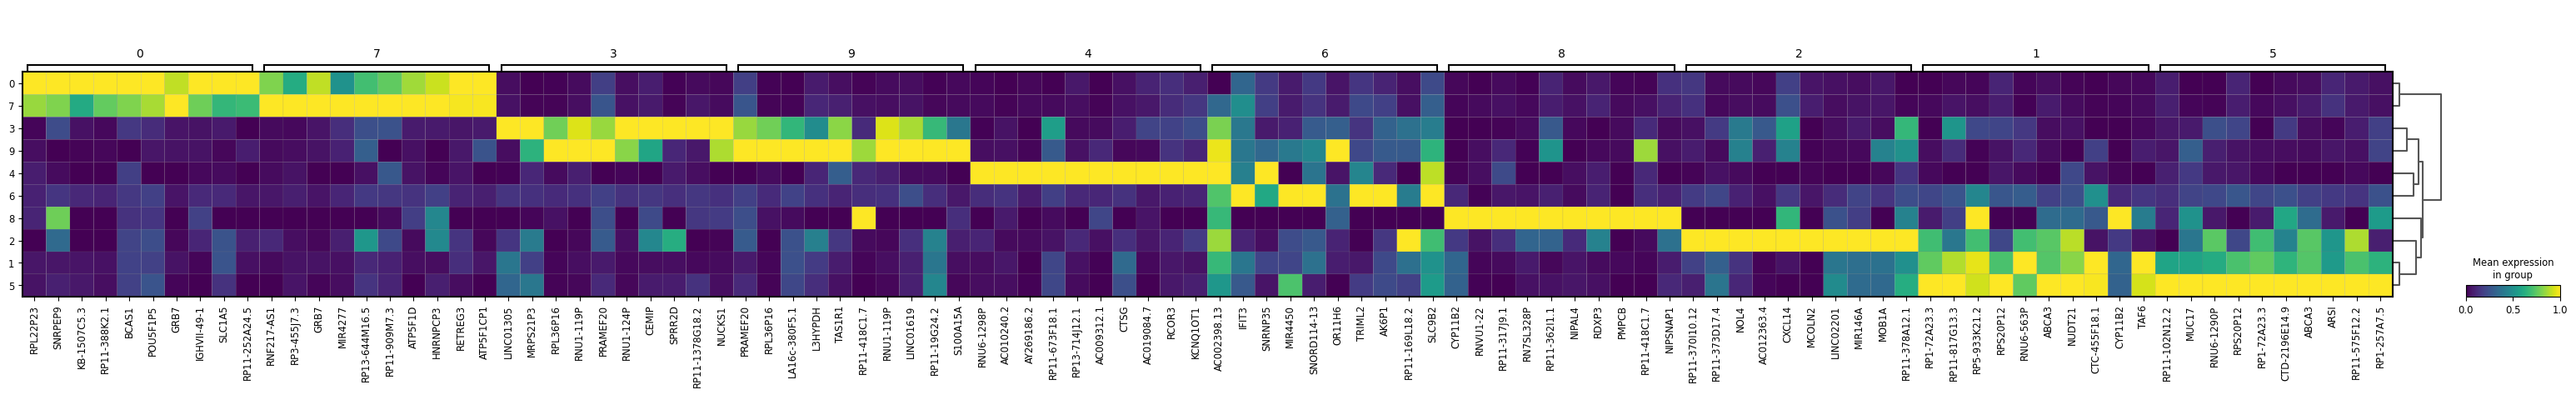

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


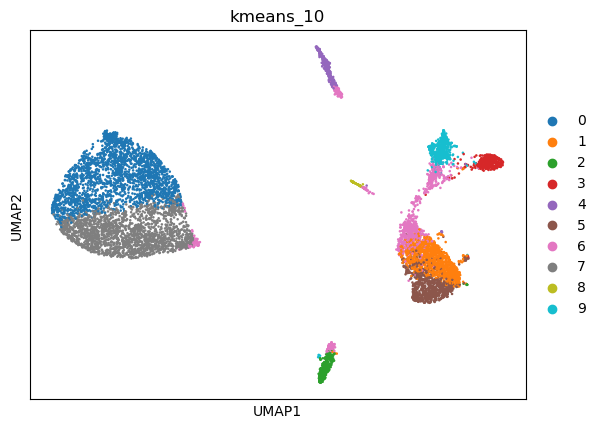

Comparison of cell type annotations:


mr_two_column_20240225171903
kmeans_10                             
0                              Neurons
1                          Macrophages
2                          Macrophages
3                         Interneurons
4                          Fibroblasts
5                              Neurons
6                         Interneurons
7                              Neurons
8                       Foveolar cells
9                          Fibroblasts

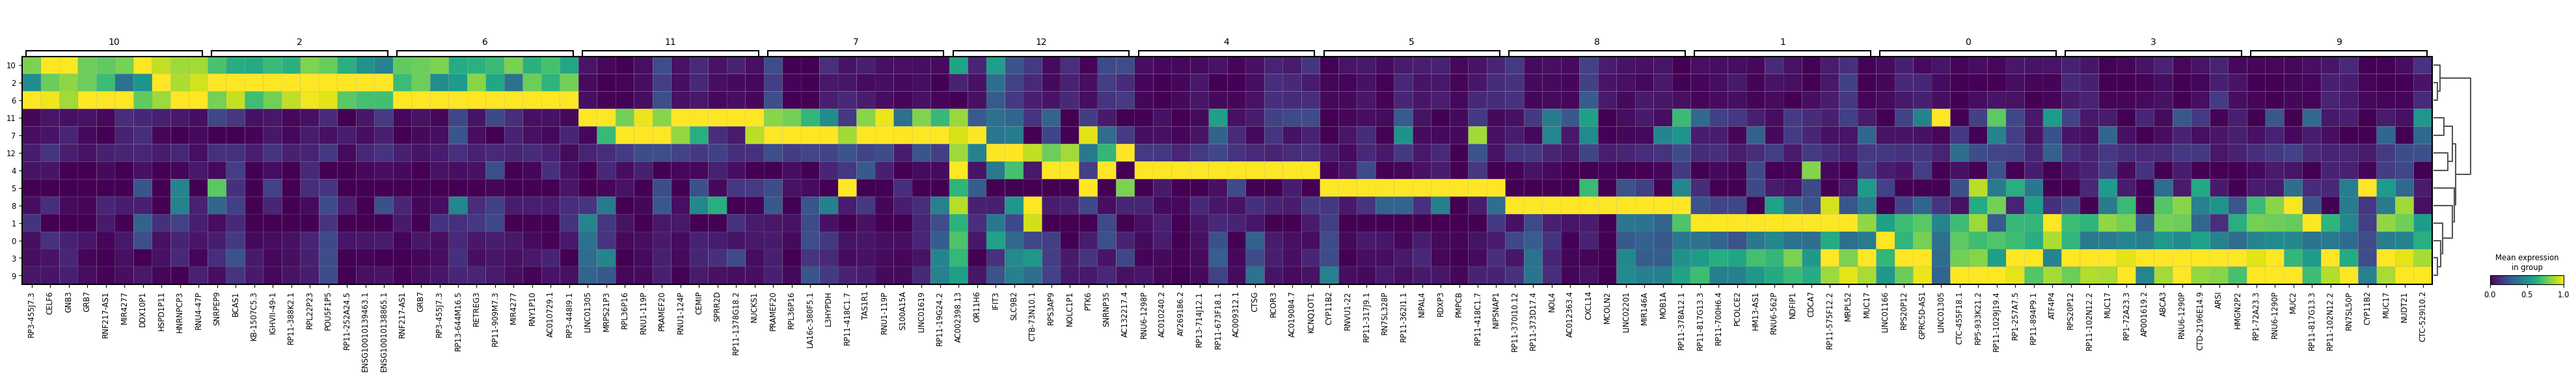

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


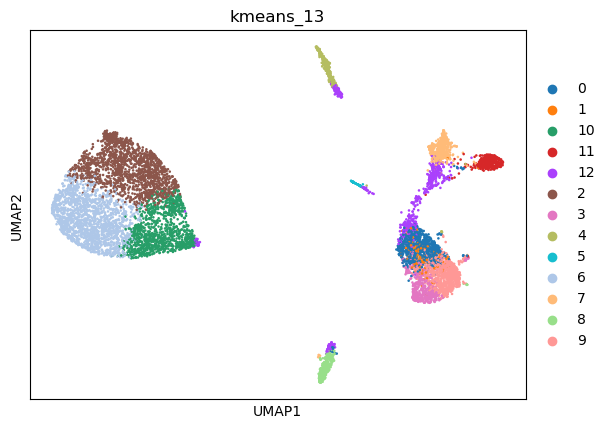

Comparison of cell type annotations:


mr_two_column_20240225171903
kmeans_13                             
0                          Macrophages
1                            Monocytes
10                        Interneurons
11                        Interneurons
12                        Interneurons
2                    Endothelial cells
3                              Neurons
4                          Fibroblasts
5                       Foveolar cells
6                              Neurons
7                          Enterocytes
8                          Macrophages
9                         Interneurons

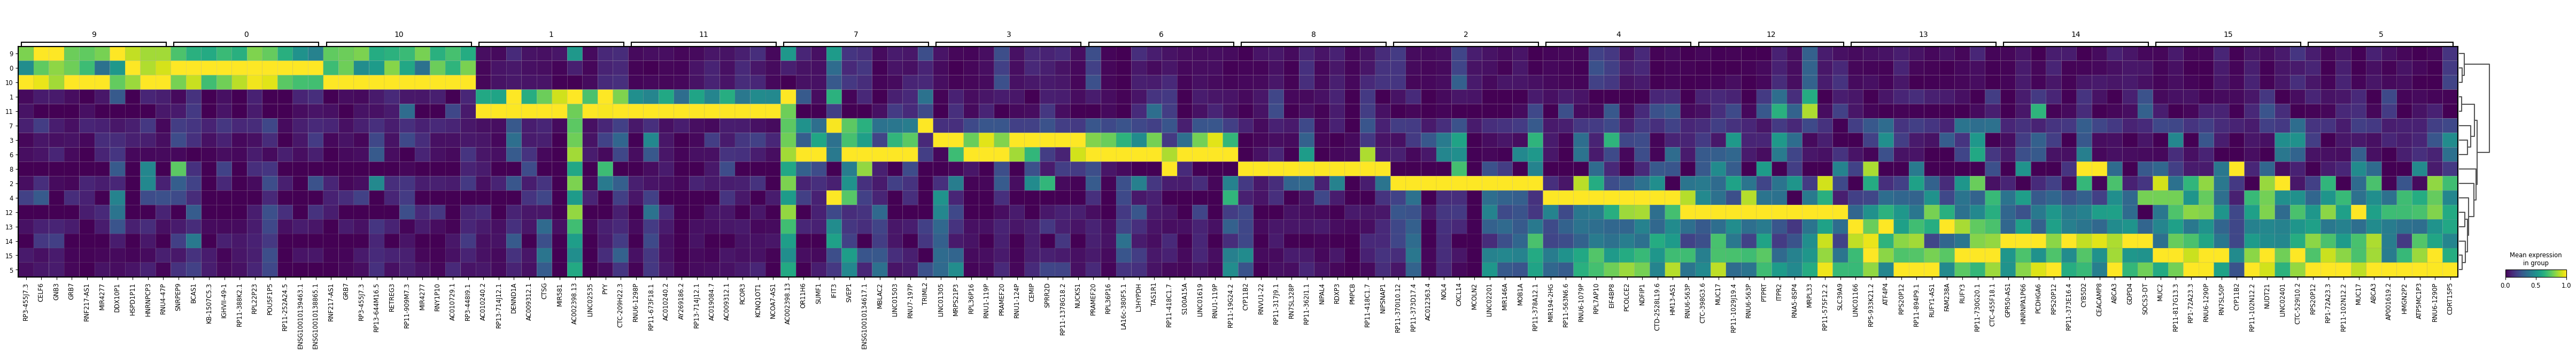

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


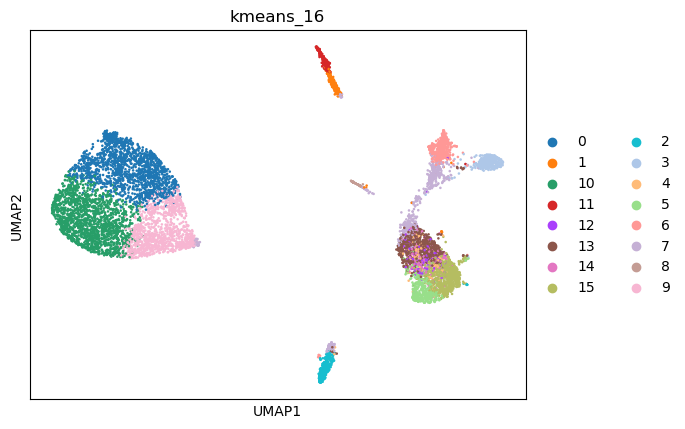

Comparison of cell type annotations:


mr_two_column_20240225171903
kmeans_16                             
0                    Endothelial cells
1                        Sertoli cells
10                             Neurons
11                         Fibroblasts
12                  Trigeminal neurons
13                        Interneurons
14                             Neurons
15                        Interneurons
2                          Macrophages
3                         Interneurons
4                      Mesangial cells
5                              Neurons
6                          Fibroblasts
7           Olfactory epithelial cells
8                       Foveolar cells
9                         Interneurons

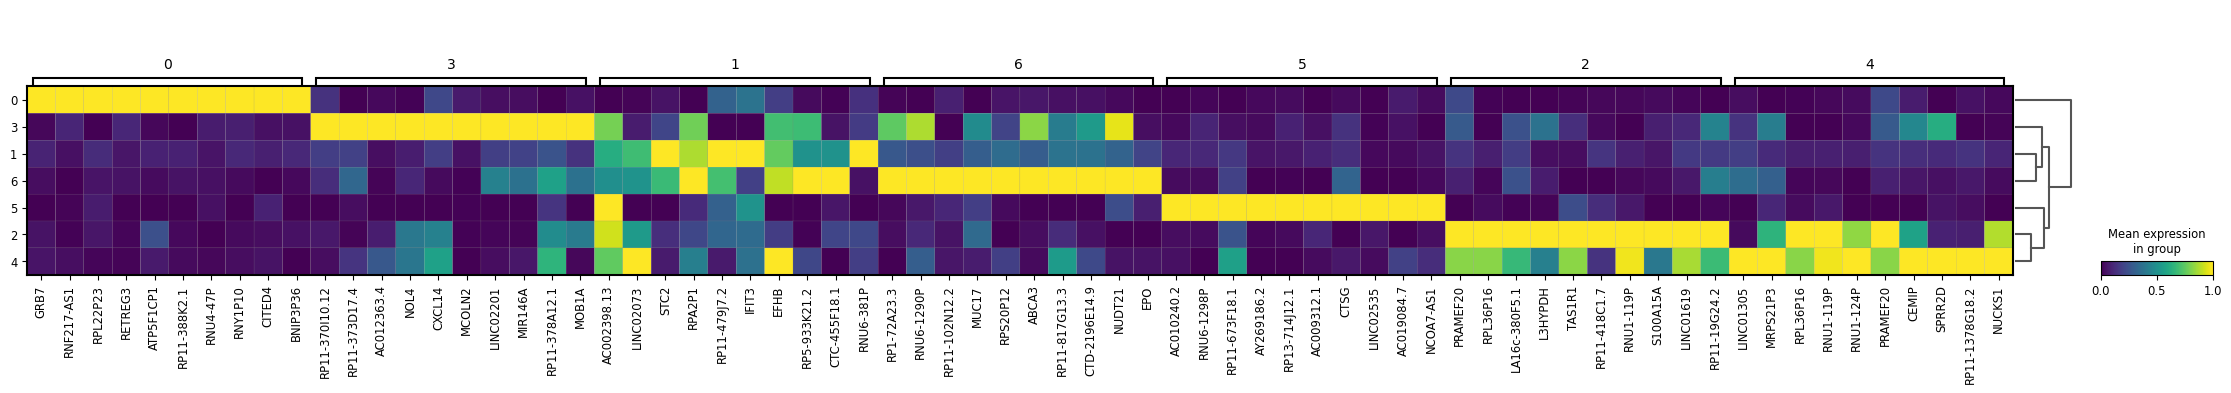

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


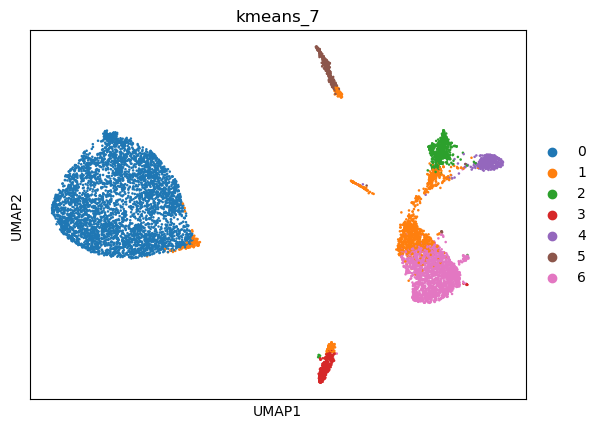

Comparison of cell type annotations:


mr_two_column_20240225171903
kmeans_7                             
0                             Neurons
1                        Interneurons
2                         Fibroblasts
3                         Macrophages
4                        Interneurons
5                         Fibroblasts
6                        Interneurons

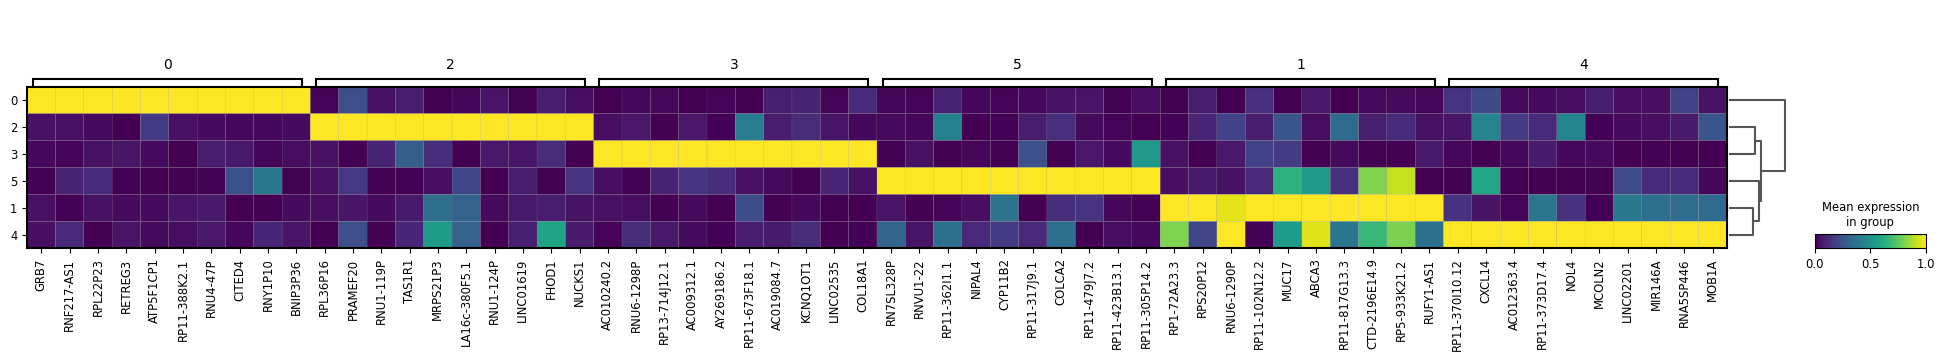

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


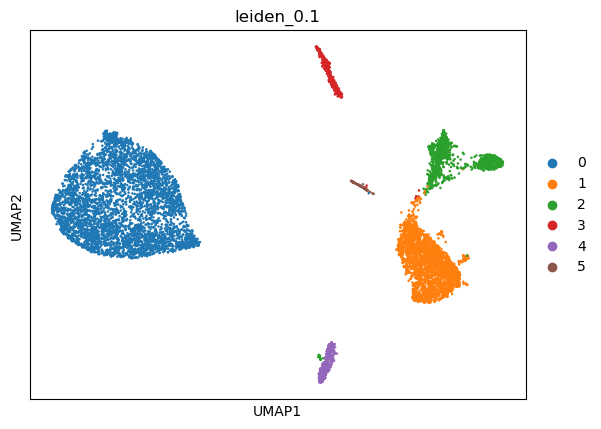

Comparison of cell type annotations:


mr_two_column_20240225171903
leiden_0.1                             
0                               Neurons
1                          Interneurons
2                           Fibroblasts
3                   Cajal-Retzius cells
4                           Fibroblasts
5                           Macrophages

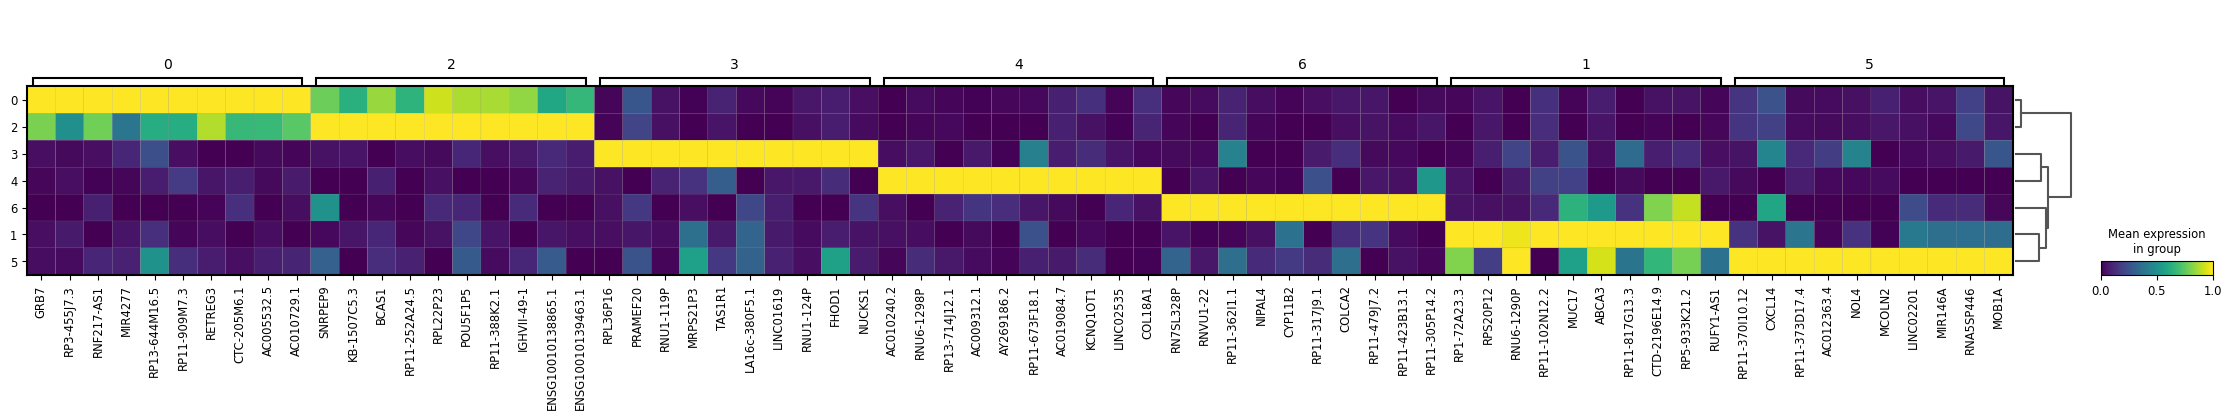

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


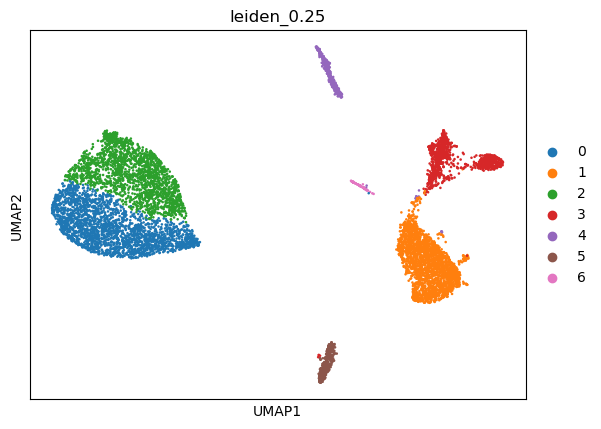

Comparison of cell type annotations:


mr_two_column_20240225171903
leiden_0.25                             
0                                Neurons
1                           Interneurons
2                      Endothelial cells
3                            Fibroblasts
4                    Cajal-Retzius cells
5                            Macrophages
6                            Macrophages

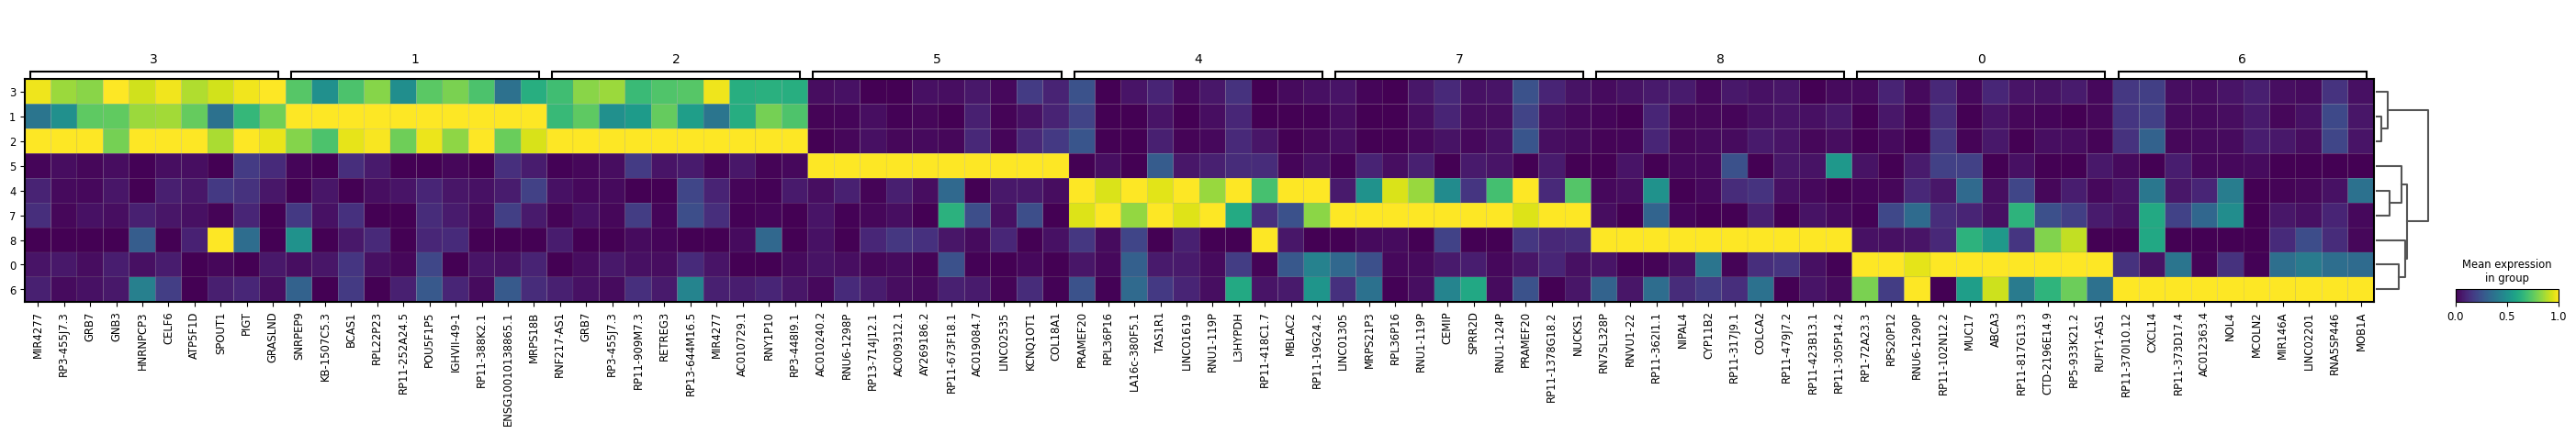

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


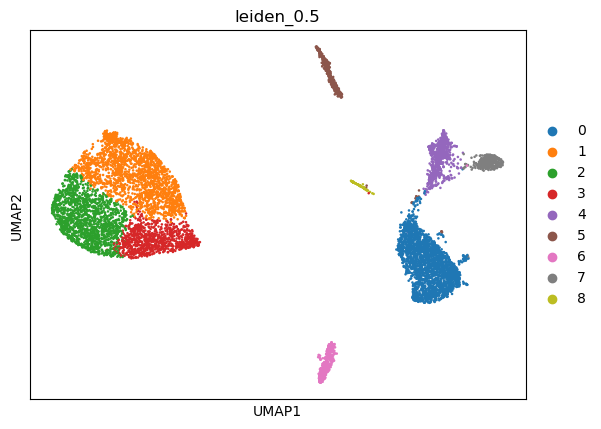

Comparison of cell type annotations:


mr_two_column_20240225171903
leiden_0.5                             
0                          Interneurons
1                           Enterocytes
2                               Neurons
3                          Interneurons
4                          Interneurons
5                   Cajal-Retzius cells
6                           Fibroblasts
7                           Fibroblasts
8                           Macrophages

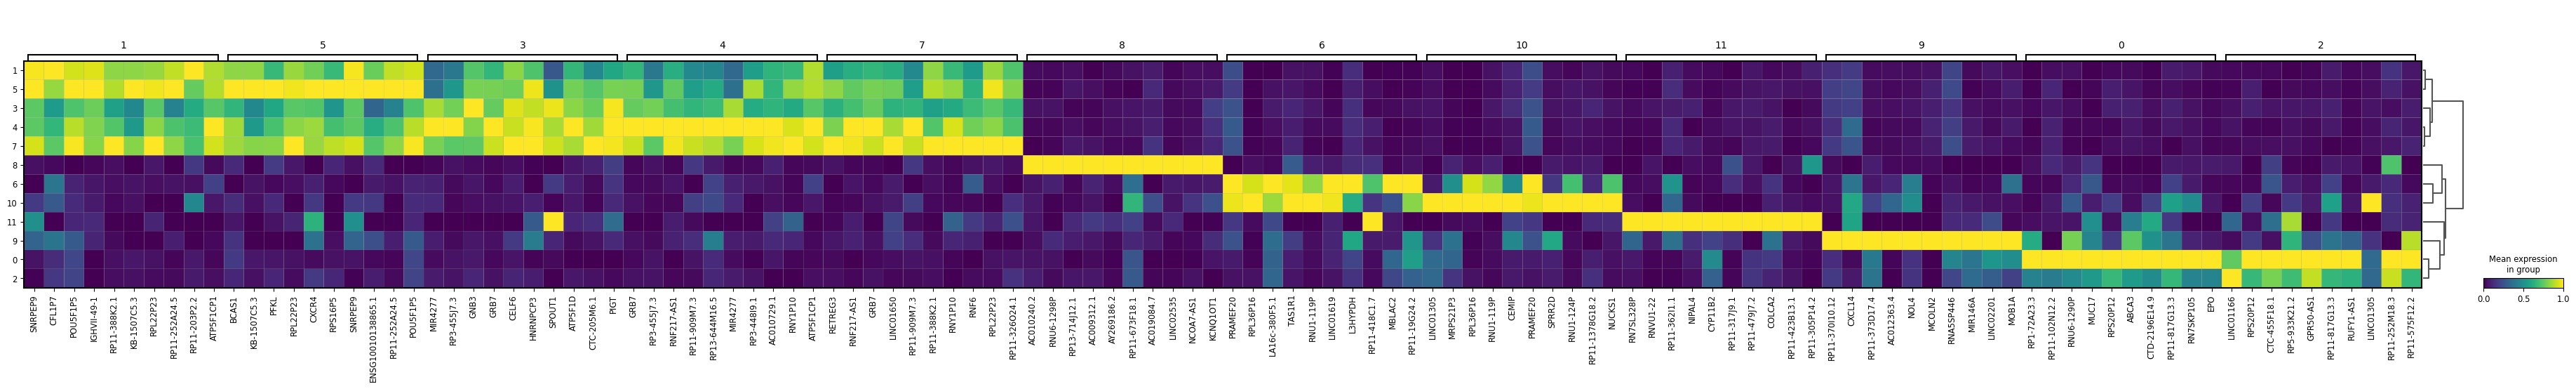

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


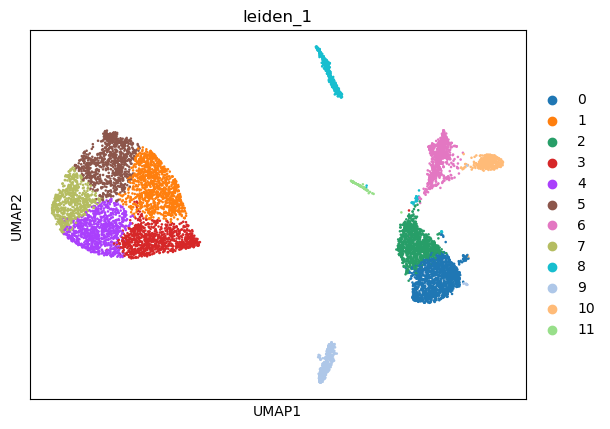

Comparison of cell type annotations:


mr_two_column_20240225171903
leiden_1                             
0                        Interneurons
1                   Endothelial cells
2                           Platelets
3                        Interneurons
4                             Neurons
5                         Enterocytes
6                        Interneurons
7                             Neurons
8                 Cajal-Retzius cells
9                         Macrophages
10                        Fibroblasts
11                        Macrophages

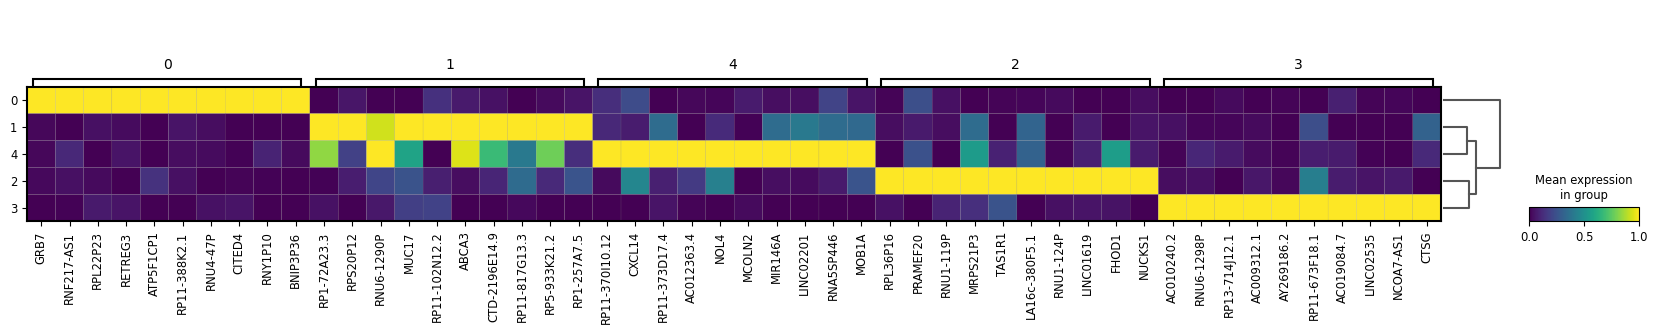

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


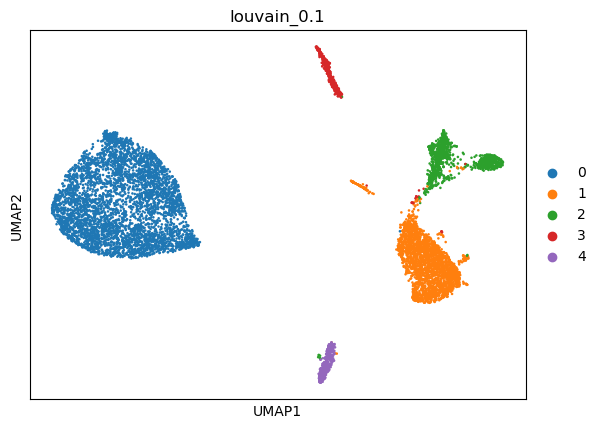

Comparison of cell type annotations:


mr_two_column_20240225171903
louvain_0.1                             
0                                Neurons
1                           Interneurons
2                           Interneurons
3                    Cajal-Retzius cells
4                            Macrophages

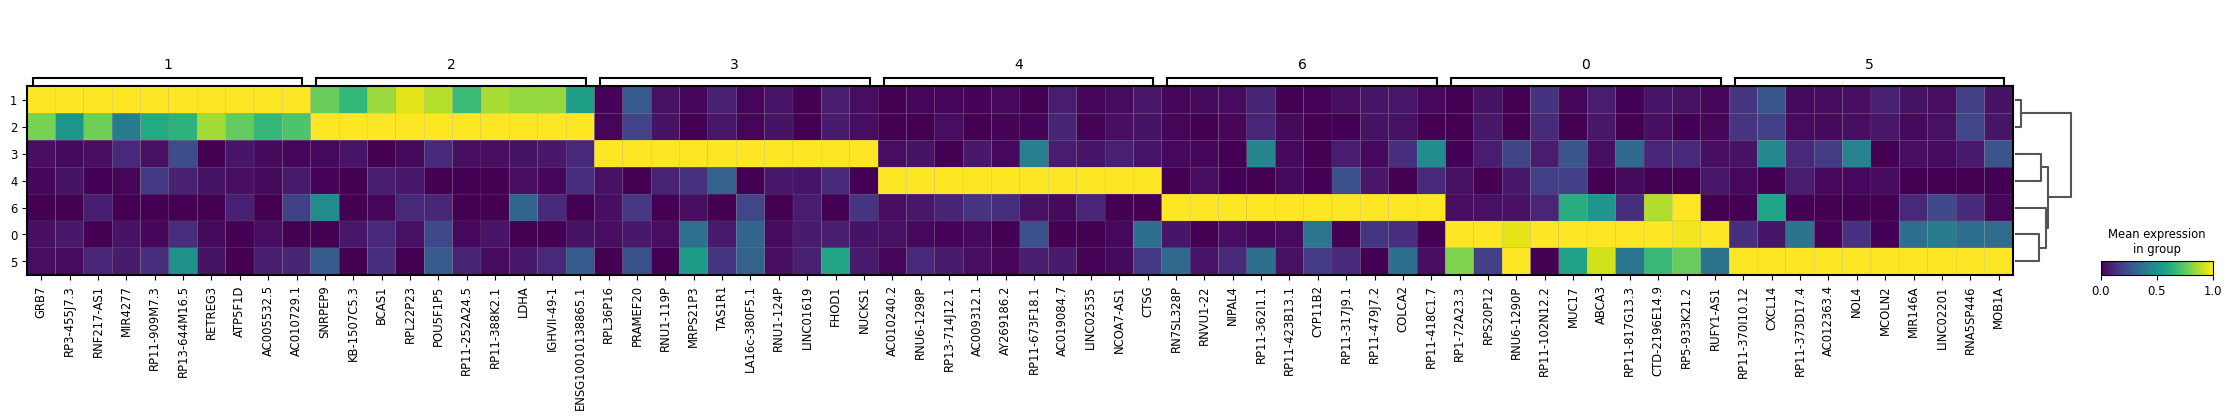

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


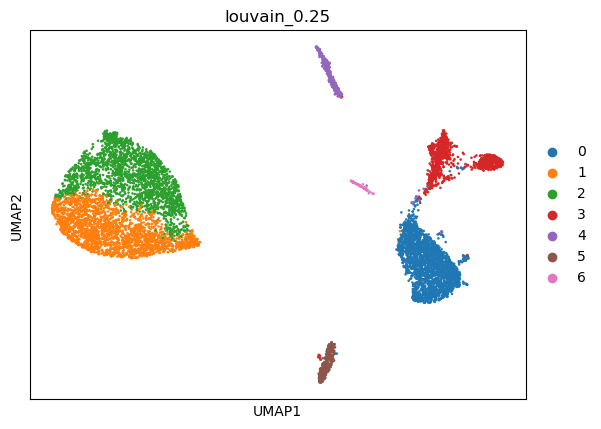

Comparison of cell type annotations:


mr_two_column_20240225171903
louvain_0.25                             
0                            Interneurons
1                                 Neurons
2                             Enterocytes
3                            Interneurons
4                     Cajal-Retzius cells
5                             Macrophages
6                             Macrophages

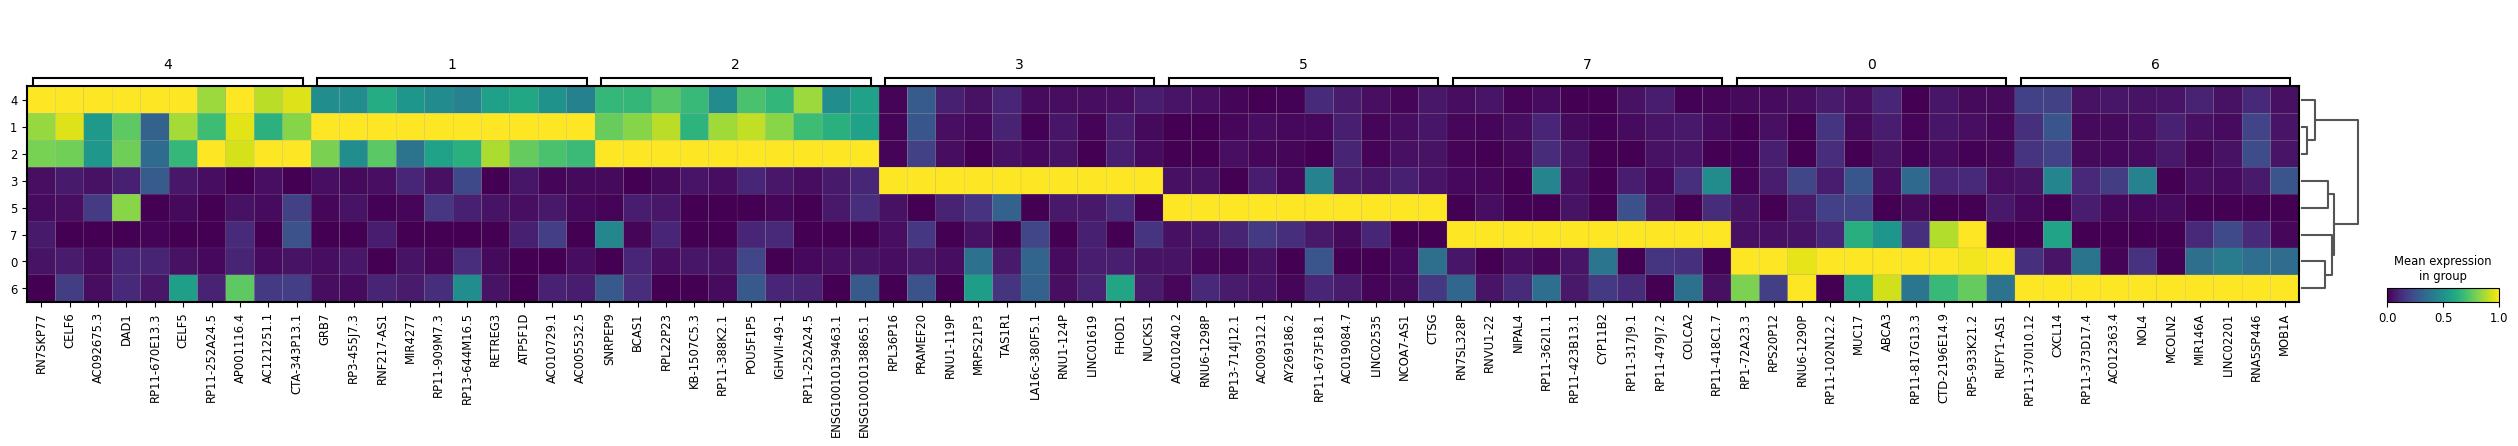

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


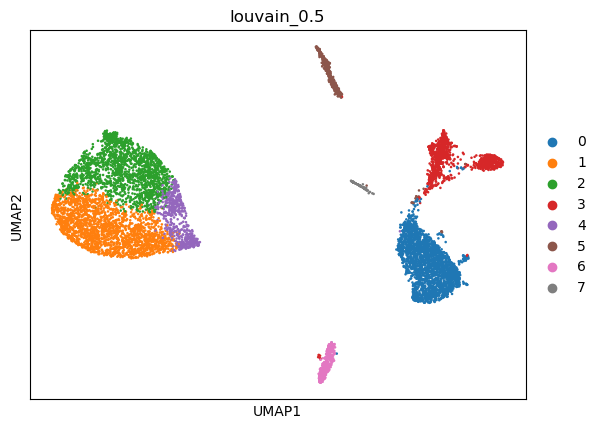

Comparison of cell type annotations:


mr_two_column_20240225171903
louvain_0.5                             
0                           Interneurons
1                                Neurons
2                            Enterocytes
3                           Interneurons
4                            Enterocytes
5                    Cajal-Retzius cells
6                            Macrophages
7                            Macrophages

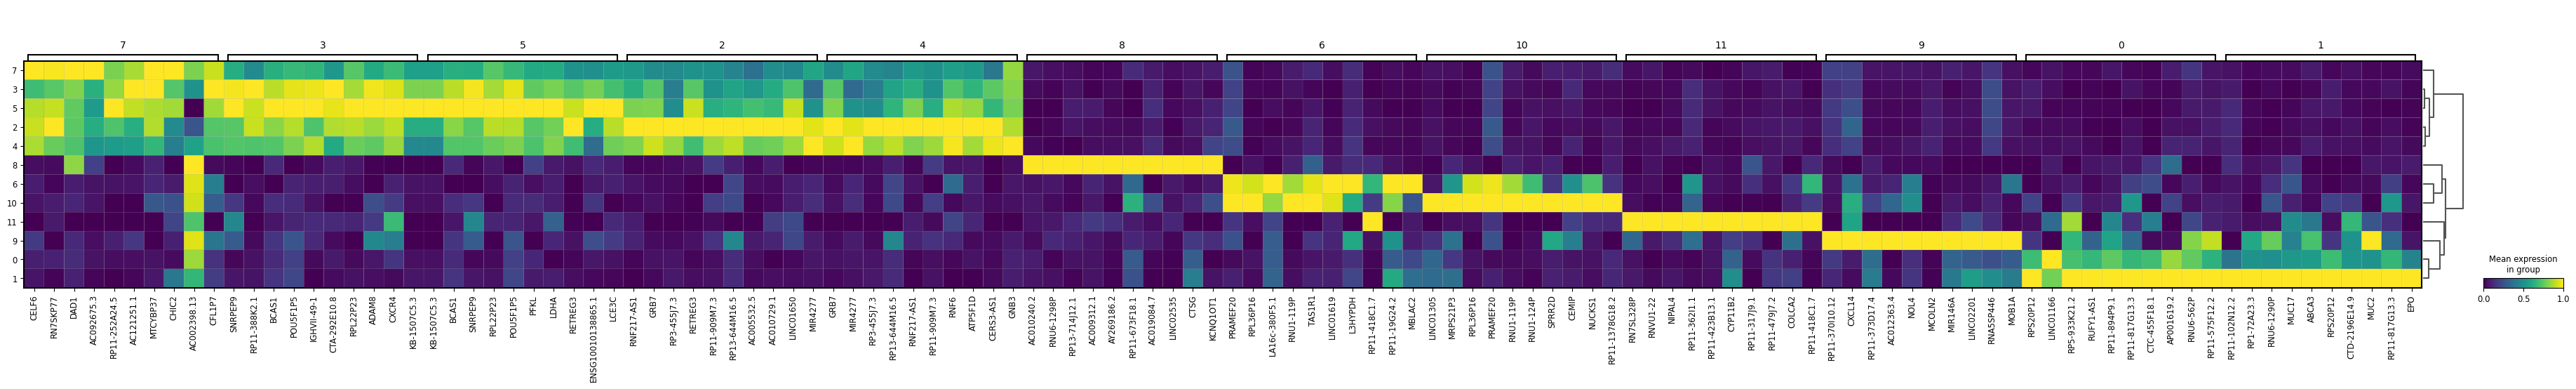

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


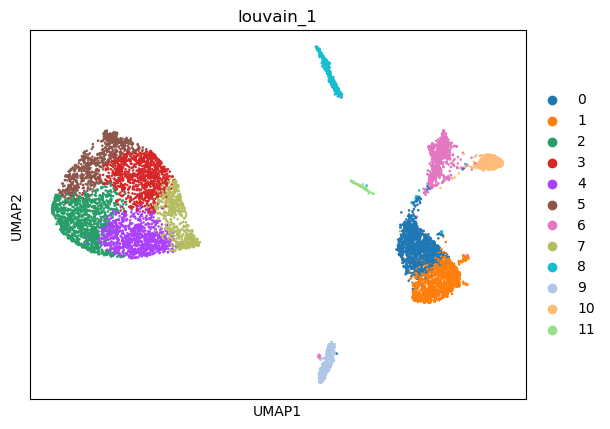

Comparison of cell type annotations:


mr_two_column_20240225171903
louvain_1                             
0                          Macrophages
1                         Interneurons
2                              Neurons
3                    Endothelial cells
4                              Neurons
5                              Neurons
6                         Interneurons
7                         Interneurons
8                  Cajal-Retzius cells
9                          Macrophages
10                        Interneurons
11                         Macrophages

In [10]:
annotation_results = auto.multiple_annotation(adata, marker_lists, clustering_column_list, rank_genes_column, celltype_column_name)

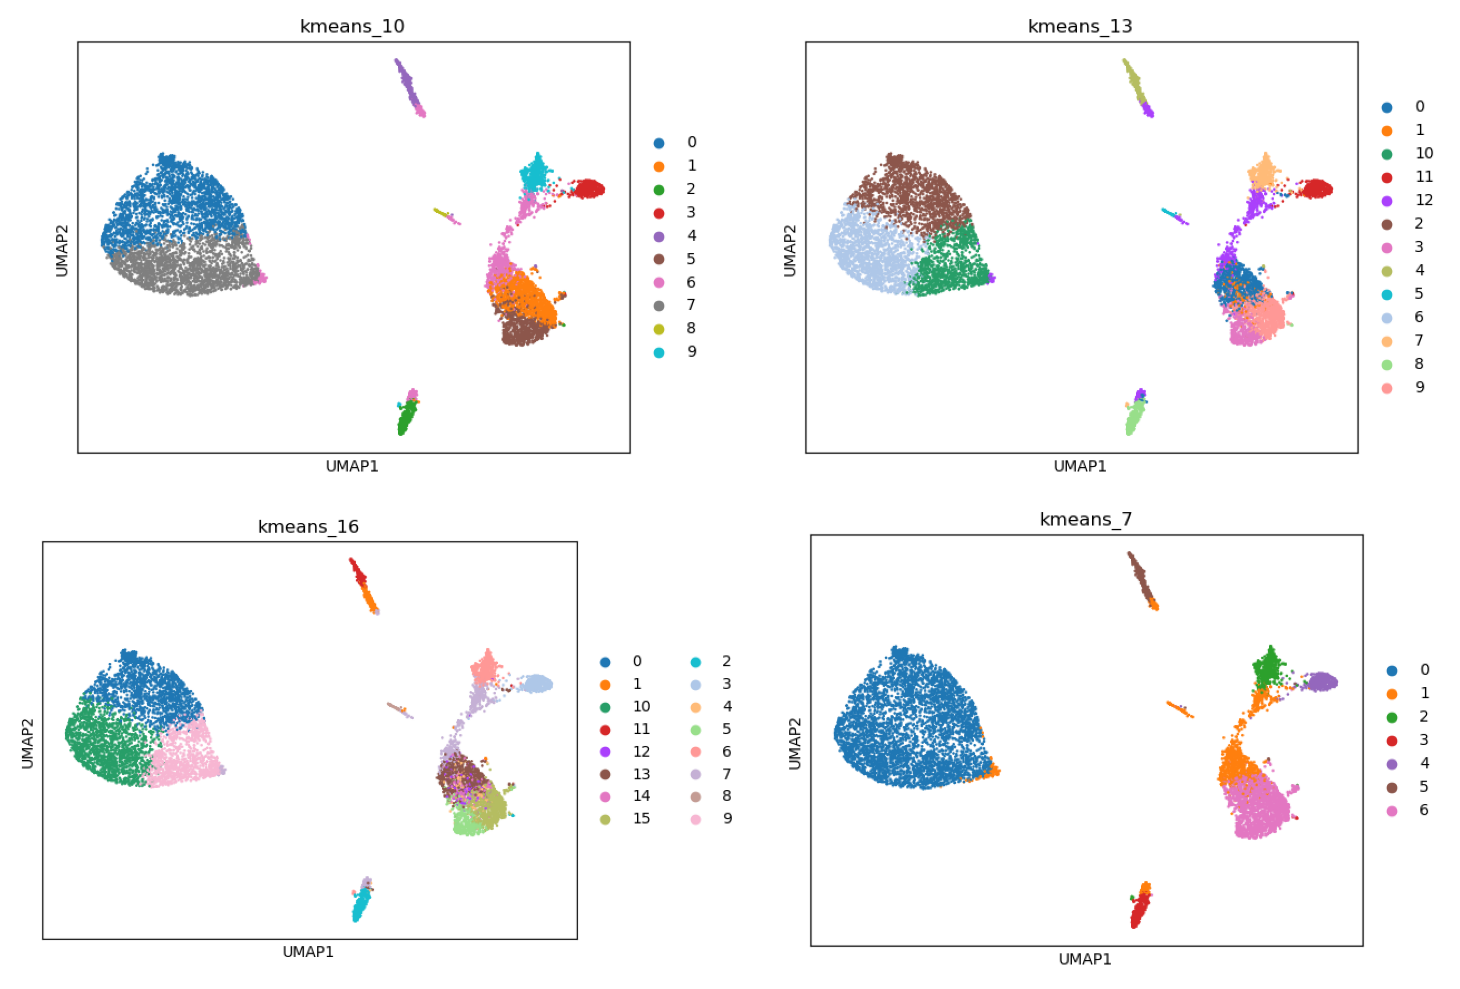

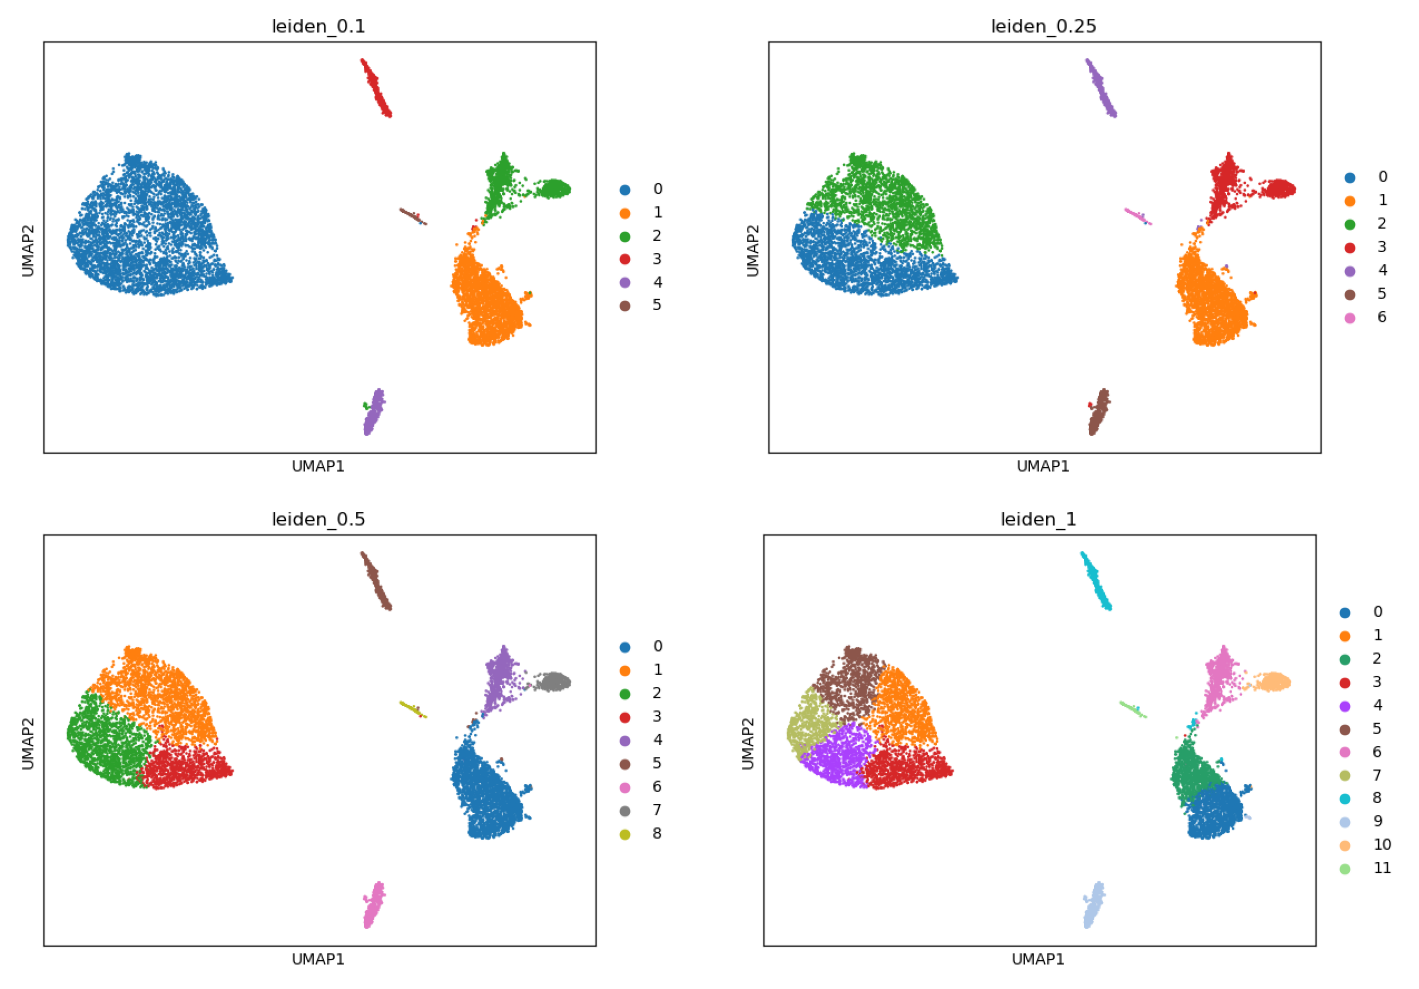

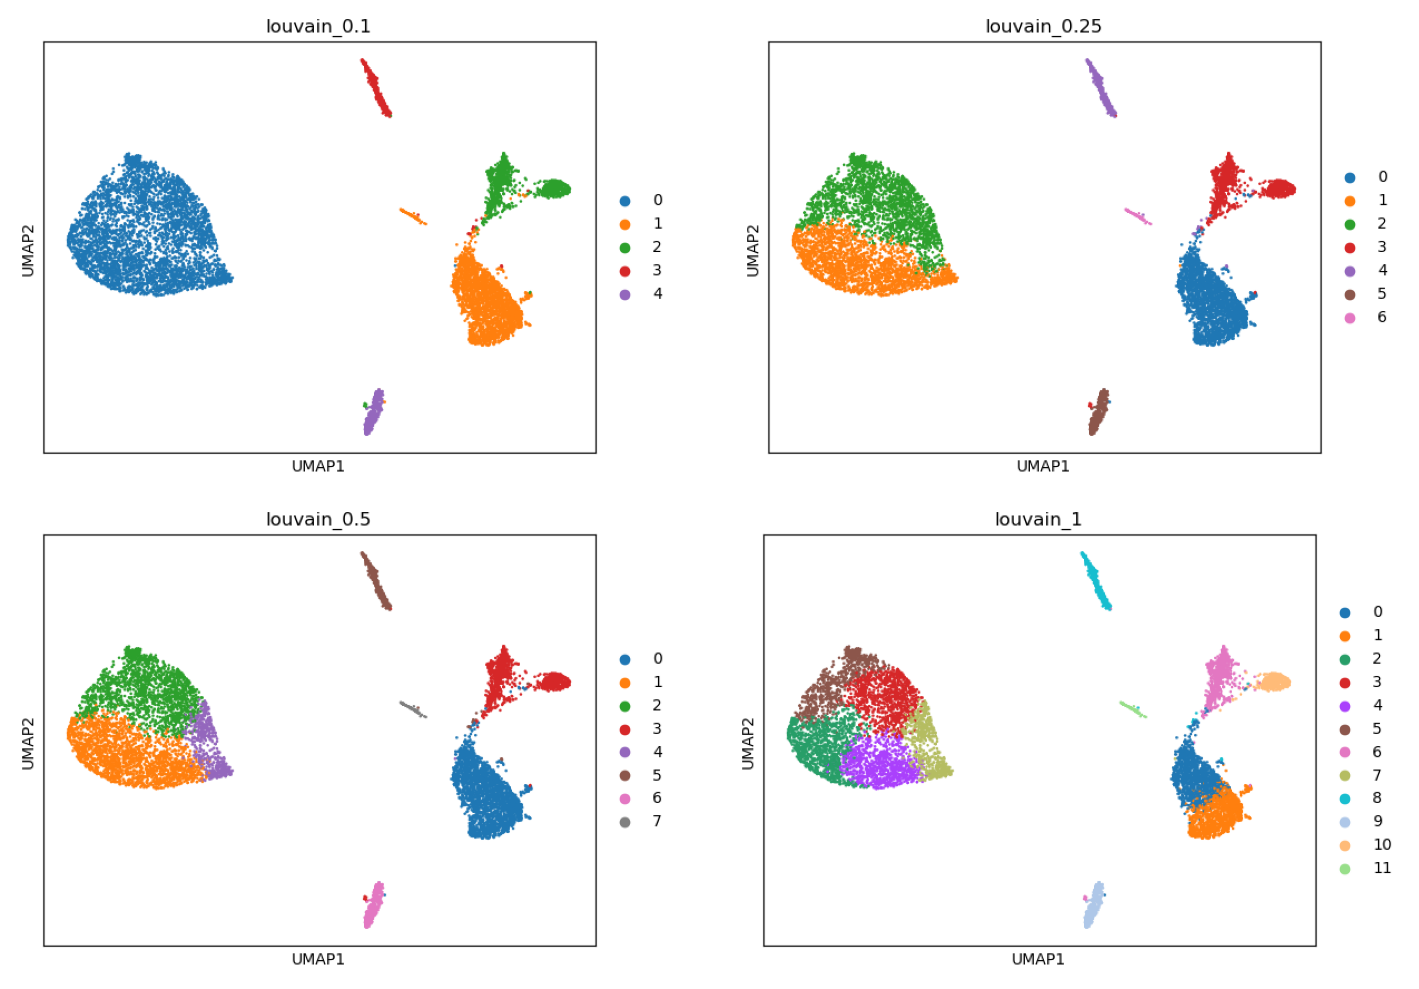

In [11]:
auto.show_umap_collection(annotation_results, clustering_column_list)

In [12]:
compared_result_df = auto.create_compare_df(adata, annotation_results, clustering_column_list)

/mnt/workspace_stud/stud3/annotate_by_marker_and_features-sorting/auto_annotation.py:468: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in df.iloc[:,0].iteritems():


kmeans_10      kmeans_13     kmeans_16 kmeans_7  \
Foveolar cells                     8              5             8            
Platelets                                                                    
Fibroblasts                     4, 9              4         11, 6     2, 5   
Mesangial cells                                                 4            
Enterocytes                                       7                          
Sertoli cells                                                   1            
Endothelial cells                                 2             0            
Olfactory epithelial cells                                      7            
Macrophages                     1, 2           0, 8             2        3   
Neurons                      0, 5, 7           3, 6     10, 14, 5        0   
Interneurons                    3, 6  10, 11, 12, 9  13, 15, 3, 9  1, 4, 6   
Monocytes                                         1                          
Trigeminal neurons                                             12            
Cajal-Retzius cells                                                          
ari_score                    0.52215         0.3893       0.37763  0.86552   

                           leiden_0.1 leiden_0.25 leiden_0.5 leiden_1  \
Foveolar cells                                                          
Platelets                                                           2   
Fibroblasts                      2, 4           3       6, 7       10   
Mesangial cells                                                         
Enterocytes                                                1        5   
Sertoli cells                                                           
Endothelial cells                               2                   1   
Olfactory epithelial cells                                              
Macrophages                         5        5, 6          8    9, 11   
Neurons                             0           0          2     4, 7   
Interneurons                        1           1    0, 3, 4  0, 3, 6   
Monocytes                                                               
Trigeminal neurons                                                      
Cajal-Retzius cells                 3           4          5        8   
ari_score                     0.95495     0.63996    0.54475  0.33815   

                           louvain_0.1 louvain_0.25 louvain_0.5    louvain_1  
Foveolar cells                                                                
Platelets                                                                     
Fibroblasts                                                                   
Mesangial cells                                                               
Enterocytes                                       2        2, 4               
Sertoli cells                                                                 
Endothelial cells                                                          3  
Olfactory epithelial cells                                                    
Macrophages                          4         5, 6        6, 7     0, 9, 11  
Neurons                              0            1           1      2, 4, 5  
Interneurons                      1, 2         0, 3        0, 3  1, 6, 7, 10  
Monocytes                                                                     
Trigeminal neurons                                                            
Cajal-Retzius cells                  3            4           5            8  
ari_score                      0.94372      0.63747      0.5654      0.33544

In [13]:
auto.find_cluster("louvain_1", 3, annotation_results)

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0  Endothelial cells      9    97                     194           1   
1        Enterocytes      9    71                     151           1   
2         Mast cells      9    66                     141           1   
3            T cells      8    49                      96           1   
4            Neurons      8   101                     205           1   

   Normalized Diff  Scaled Diff  
0         0.000000            0  
1         0.000000            0  
2         0.111111           22  
3         0.000000            0  
4         0.000000            0

In [14]:
best_cluter = str(adata.uns["best_cluster"])
display(best_cluter)

'leiden_0.1'

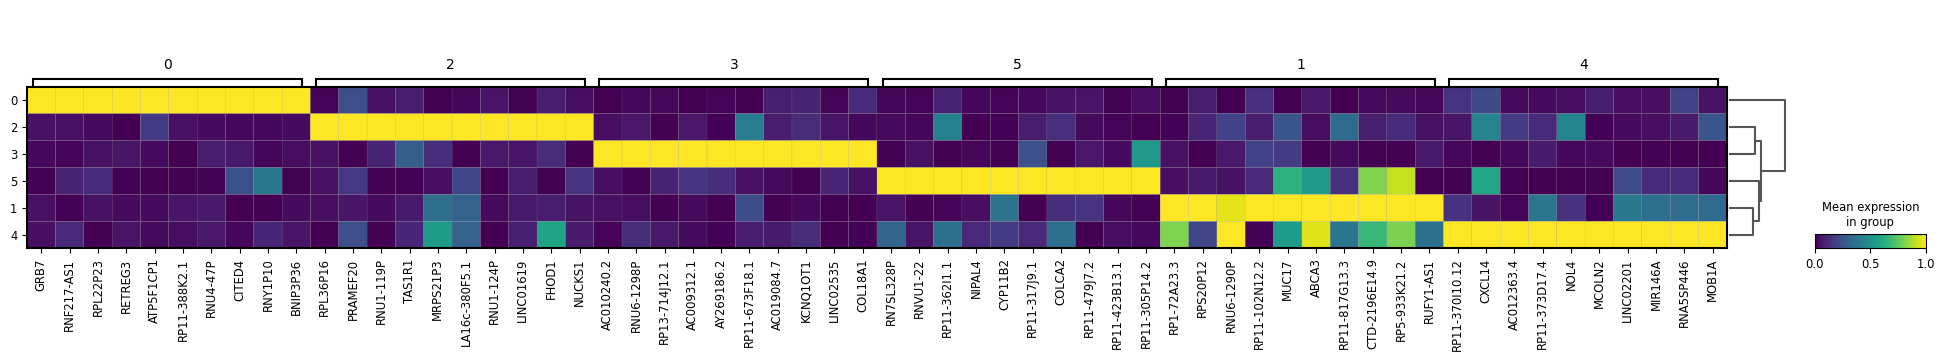

Tables of cell type annotation with clustering leiden_0.1 and marker list two_column_20240225171903:


Cluster 0  Score  Hits  Number of marker genes  Mean of UI  \
0            Neurons     28   115                     205           1   
1        Enterocytes     26    87                     151           1   
2  Endothelial cells     25   117                     194           1   
3       Interneurons     25   122                     224           1   
4            T cells     24    63                      96           1   

   Adjacent Disparity  
0                  14  
1                   8  
2                   0  
3                   8  
4                   0

Cluster 4  Score  Hits  Number of marker genes  Mean of UI  \
0       Fibroblasts      5    73                     176           1   
1       Macrophages      5    55                     134           1   
2         Platelets      5    48                     131           1   
3  Epithelial cells      5    45                     131           1   
4        Mast cells      5    47                     141           1   

   Adjacent Disparity  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0

Cluster 3  Score  Hits  Number of marker genes  Mean of UI  \
0    Cajal-Retzius cells      5    37                      85           1   
1            Fibroblasts      5    64                     176           1   
2      Endothelial cells      5    62                     194           1   
3          Sertoli cells      4    29                      66           1   
4  Proximal tubule cells      4    33                      79           1   

   Adjacent Disparity  
0                   0  
1                   0  
2                  20  
3                   0  
4                   0

Cluster 1  Score  Hits  Number of marker genes  Mean of UI  \
0  Interneurons     11    84                     224           1   
1       Neurons     10    78                     205           1   
2     Platelets     10    46                     131           1   
3   Macrophages      9    55                     134           1   
4    Mast cells      9    49                     141           1   

   Adjacent Disparity  
0                  18  
1                   0  
2                  20  
3                   0  
4                  22

Cluster 2  Score  Hits  Number of marker genes  Mean of UI  \
0           Fibroblasts      8    72                     176           1   
1          Interneurons      8    88                     224           1   
2               Neurons      7    83                     205           1   
3  Taste receptor cells      6     9                      20           1   
4           Enterocytes      6    58                     151           1   

   Adjacent Disparity  
0                   0  
1                  25  
2                  29  
3                   0  
4                   0

Cluster 5  Score  Hits  Number of marker genes  Mean of UI  \
0     Macrophages      3    39                     134           1   
1   Erythroblasts      2    11                      26           1   
2    Luteal cells      2    10                      29           1   
3       Microglia      2    23                      72           1   
4  T memory cells      2    17                      55           1   

   Adjacent Disparity  
0                  33  
1                   0  
2                   0  
3                   0  
4                   0

/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/stud3/.conda/envs/marker-sort/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


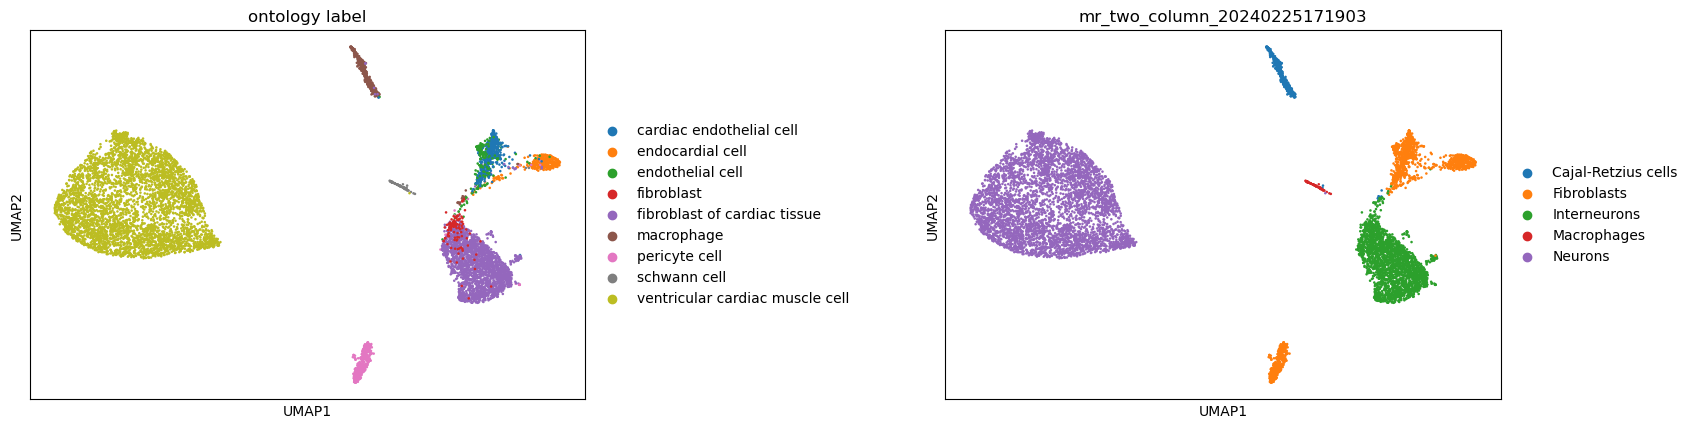

In [15]:
reference_best = wrap.run_annotation(adata, SCSA=False, marker_lists=marker_lists, reference_obs="ontology label", show_comparison=False,
                    clustering_column=best_cluter, rank_genes_column=rank_genes_column, 
                    ignore_overwrite=True, verbose=False, show_plots=True, show_ct_tables=True, 
                    celltype_column_name=celltype_column_name)

Delete created marker lists.

In [16]:
if delete_lists:
    mr.delete_files(marker_lists)

File deleted: /mnt/workspace_stud/stud3/annotate_by_marker_and_features-sorting/two_column_20240225171903
